# TP CUDA - October 2022

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt

import pandas as pd

import warnings
warnings.filterwarnings('ignore')

## Part 1 : Pi

### Compilation and performance evaluation

In [34]:
!make pi
!make pi_mt
!make pi_atomic
!make pi_msr

In [21]:
df_pi_1_thread = pd.read_csv("pi.csv")
df_pi_mt = pd.read_csv("pi_mt.csv")
df_pi_atomic = pd.read_csv("pi_atomic.csv")
df_pi_msr = pd.read_csv("pi_msr.csv")

df_pi_1_thread["method"] = "1_thread"
df_pi_mt["method"] = "n_threads"
df_pi_atomic["method"] = "atomic"
df_pi_msr["method"] = "reduction"

df_pi = pd.concat([df_pi_1_thread, df_pi_mt, df_pi_atomic, df_pi_msr])

### Performance analysis

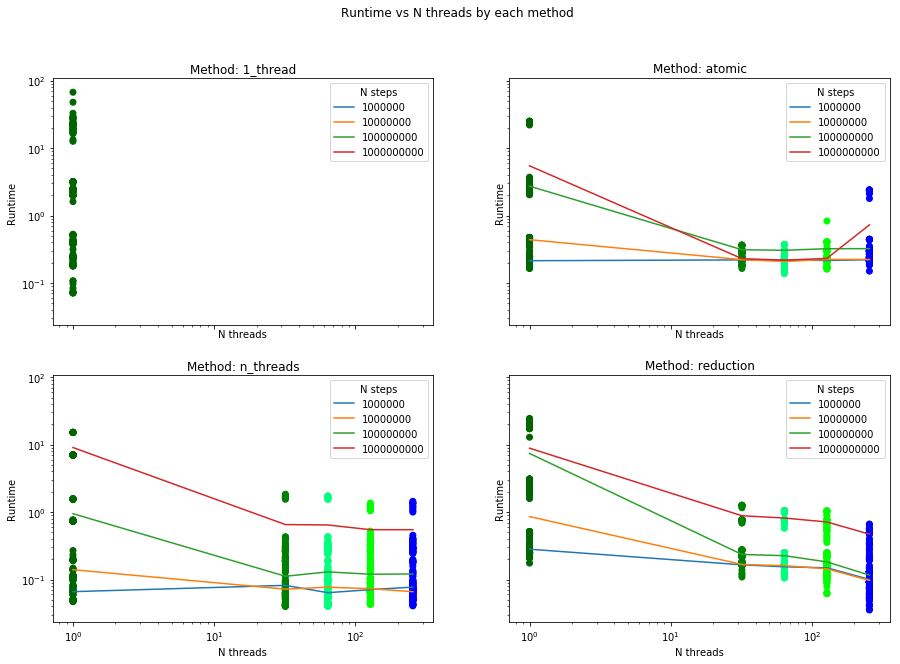

In [24]:
color_num_steps = {1 : "darkgreen", 32 : "green", 64 : "springgreen", 128 : "lime", 256: "blue"}
ax_methods = { "1_thread": [0,0], "n_threads": [1, 0], "atomic": [0, 1], "reduction": [1, 1]}

x = 'num_steps'
y = 'runtime'

fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)

for x_value in df_pi[x].unique():
    for method in df_pi['method'].unique(): 
        ax_x, ax_y = ax_methods[method];
        ax = axs[ax_x, ax_y]

        df_x_value = df_pi[(df_pi[x] == int(x_value))]
        df_plot = df_x_value[df_x_value['method'] == method]
        
        mean_stats = df_plot.groupby([x,'method', 'num_threads']).mean().reset_index()
        
        ax.plot(mean_stats['num_threads'], mean_stats[y], linestyle="solid")
        sct = ax.scatter(df_plot['num_threads'], df_plot[y], c=df_plot['num_threads'].apply(lambda n : color_num_steps[n]))
        ax.set_xlabel("N threads")
        ax.set_ylabel("Runtime")
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_title("Method: " + method)
        ax.legend(title="N steps", labels=[1000000, 10000000, 100000000, 1000000000])
    
fig.suptitle('Runtime vs N threads by each method', fontsize='large')
plt.show()

In the previous diagrams, we can see the comparaison between the 4 implementation according the number of threads used vs the runtime. 

We can see than more threads we use for the reduction implementation, faster the execution. However, the differences in runtime for the atomic method don't change sufficiently to afirm the same. This is due to the fact that there's a bottleneck in the atomicity of the variable that is being handle by multiple threads. This bottleneck doesn't allow the parallelization to continue increasing its performance. In the other side, the reduction method doesn't have that bottleneck, due to it is not using an atomic variable, instead it is using a shared memory between the threads and computing partial results in batches while reducing the amount of running thread after each iteration. This allows the parallelization to increase the performance due to more threads we have more parallelizable is the logic (smaller batches).

The counterside of having too many blocks/threads is the loss of precision, this happens due to we're using the float type instead of the double type. Therefore, more singular operations we have, more precision we're going to lose. To avoid this it is possible to use types with a bigger precision like `double` or try to acheive a balance between the the amount of blocks/threads.

Text(0.5, 0.98, 'Runtime Analysis of each method by N steps')

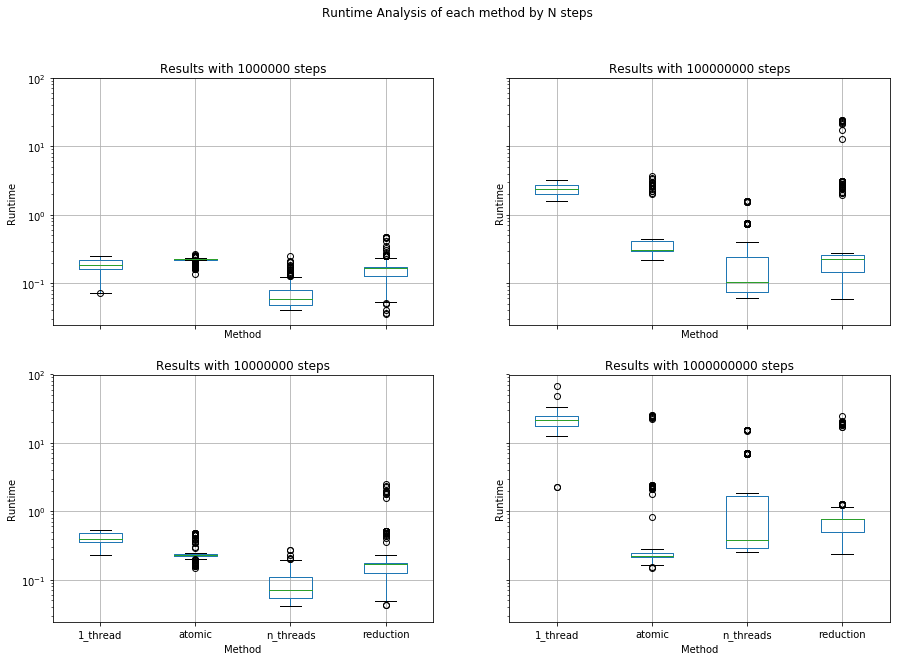

In [25]:
ax_num_steps = { 1000000: [0,0], 10000000: [1, 0], 100000000: [0, 1], 1000000000: [1, 1]}

fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)

for x_value in df_pi['num_steps'].unique():
  ax_x, ax_y = ax_num_steps[x_value];
  ax = axs[ax_x, ax_y]

  df_x_value = df_pi[(df_pi['num_steps'] == int(x_value))]
  df_threads = df_x_value.pivot(columns='method', values='runtime')
  df_threads.boxplot(ax=ax)
  plt.yscale('log')
  ax.set_title('Results with ' + str(x_value) + ' steps')
  ax.set_xlabel('Method')
  ax.set_ylabel('Runtime')

fig.suptitle('Runtime Analysis of each method by N steps', fontsize='large')

In the latest diagram, we have the general results of all executions, all the number of threads and steps with a repetition of 10 times by each execution. They are divided by method and by N steps.

## Part 2 : Vector

### Compilation and performance evaluation

In [ ]:
!make vector
!make vector_atomic
!make vector_shared

### Performance analysis

In [26]:
df_vector = pd.read_csv("vector.csv")
df_atomic = pd.read_csv("vector_atomic.csv")
df_shared = pd.read_csv("vector_shared.csv")


df_vector["method"] = "1_thread"
df_atomic["method"] = "atomic"
df_shared["method"] = "shared"

df_vector_methods = pd.concat([df_vector, df_atomic, df_shared])

df_vector_methods["S"] = df_vector_methods["N"] * df_vector_methods["M"]

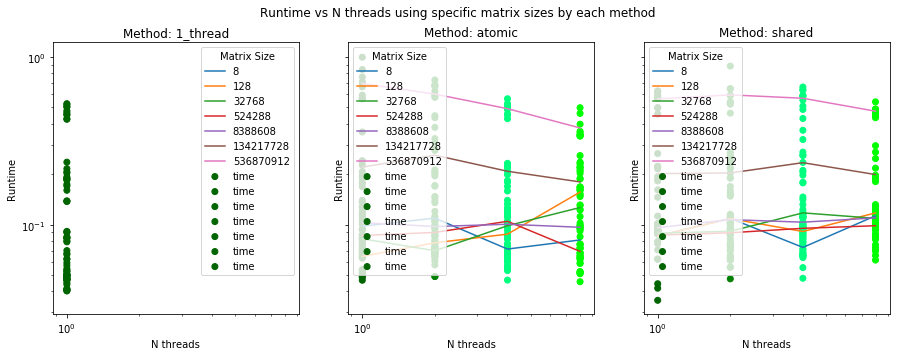

In [27]:
color_num_threads = {1 : "darkgreen", 2 : "green", 4 : "springgreen", 8 : "lime"}
ax_methods = { "1_thread": [0,0], "atomic": [1, 0], "shared": [2, 0]}

x = 'S'
y = 'time'

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

for x_value in df_vector_methods[x].unique():
    for method in df_vector_methods['method'].unique(): 
        ax_x, ax_y = ax_methods[method];
        ax = axs[ax_x]

        df_x_value = df_vector_methods[(df_vector_methods[x] == int(x_value))]
        df_plot = df_x_value[df_x_value['method'] == method]
        
        mean_stats = df_plot.groupby([x,'method', 'num_threads']).mean().reset_index()
        
        ax.plot(mean_stats['num_threads'], mean_stats[y], linestyle="solid", label=x_value)
        sct = ax.scatter(df_plot['num_threads'], df_plot[y], c=df_plot['num_threads'].apply(lambda n : color_num_threads[n]))
        ax.set_xlabel("N threads")
        ax.set_ylabel("Runtime")
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_title("Method: " + method)
        ax.legend(title="Matrix Size")
    
fig.suptitle('Runtime vs N threads using specific matrix sizes by each method', fontsize='large')
plt.show()

In the previous diagram we can see the comparaison between the 3 methods according the number of threads used vs the runtime. The first method doesn't use atomics or shared memory, so its block is computing a line of the matrix A with 1 thread. 

Text(0.5, 1.0, 'Runtime Analysis of each method by matrix size')

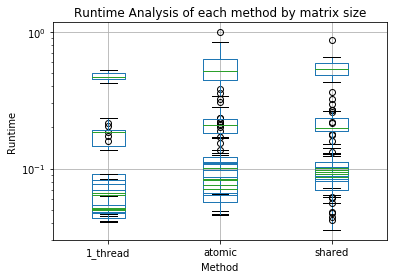

In [31]:
color_s = {8 : "violet", 128 : "green", 32768 : "yellow", 524288 : "lime", 8388608: "red", 134217728: "black", 536870912: "blue"}

x = 'S'

for x_value in df_vector_methods[x].unique():
  df_x_value = df_vector_methods[(df_vector_methods[x] == int(x_value))]
  df_threads = df_x_value.pivot(columns='method', values='time')
  df_threads.boxplot()

plt.yscale('log')
plt.xlabel('Method')
plt.ylabel('Runtime')
plt.title('Runtime Analysis of each method by matrix size', fontsize='large')

In the latest diagram, we have the general results of all executions, all the number of threads and matrix sizes. The idea is to visualize the mean, medium and standard deviation of each method for each matrix size. Each color is a different matrix size. More in the top, bigger the matrix size. 